In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from pyHalo.PresetModels.cdm import CDM

def plot_mc_relation(ax, realization, kwargs_plot):
    masses_1 = []
    c_1 = []
    masses_2 = []
    c_2 = []
    masses_3 = []
    c_3 = []
    masses_4 = []
    c_4 = []
    masses_5 = []
    c_5 = []
    masses_6 = []
    c_6 = []
    masses_7 = []
    c_7 = []
    z_bins = [0.3, 0.6, 1.0, 1.4, 1.7, 2.0, 2.5]
    for halo in realization.halos:
        if halo.is_subhalo: # subhalos have a lot of scatter because their concentration is evaluated at infall
            continue
        if halo.z < z_bins[0]:
            masses_1.append(halo.mass)
            c_1.append(halo.c)
        elif halo.z < z_bins[1]:
            masses_2.append(halo.mass)
            c_2.append(halo.c)
        elif halo.z < z_bins[2]:
            masses_3.append(halo.mass)
            c_3.append(halo.c)
        elif halo.z < z_bins[3]:
            masses_4.append(halo.mass)
            c_4.append(halo.c)
        elif halo.z < z_bins[4]:
            masses_5.append(halo.mass)
            c_5.append(halo.c)
        elif halo.z < z_bins[5]:
            masses_6.append(halo.mass)
            c_6.append(halo.c)
        elif halo.z < z_bins[5]:
            masses_7.append(halo.mass)
            c_7.append(halo.c)
    ax.scatter(np.log10(masses_1), np.log10(c_1), color='k', **kwargs_plot)
    ax.scatter(np.log10(masses_2), np.log10(c_2), color='g', **kwargs_plot)
    ax.scatter(np.log10(masses_3), np.log10(c_3), color='r', **kwargs_plot)
    ax.scatter(np.log10(masses_4), np.log10(c_4), color='m', **kwargs_plot)
    ax.scatter(np.log10(masses_5), np.log10(c_5), color='y', **kwargs_plot)
    ax.scatter(np.log10(masses_6), np.log10(c_6), color='b', **kwargs_plot)
    ax.scatter(np.log10(masses_7), np.log10(c_7), color='0.5', **kwargs_plot)
    

# Custom MC relations

### Modifying existing concentration-mass relations

To modify an existing concentration-mass relation, such as the Ludlow et al. 2016 model or the one by Diemer and Joyce (2019), the easiest thing is to create a custom class 

Text(0, 0.5, 'log10 concentration')

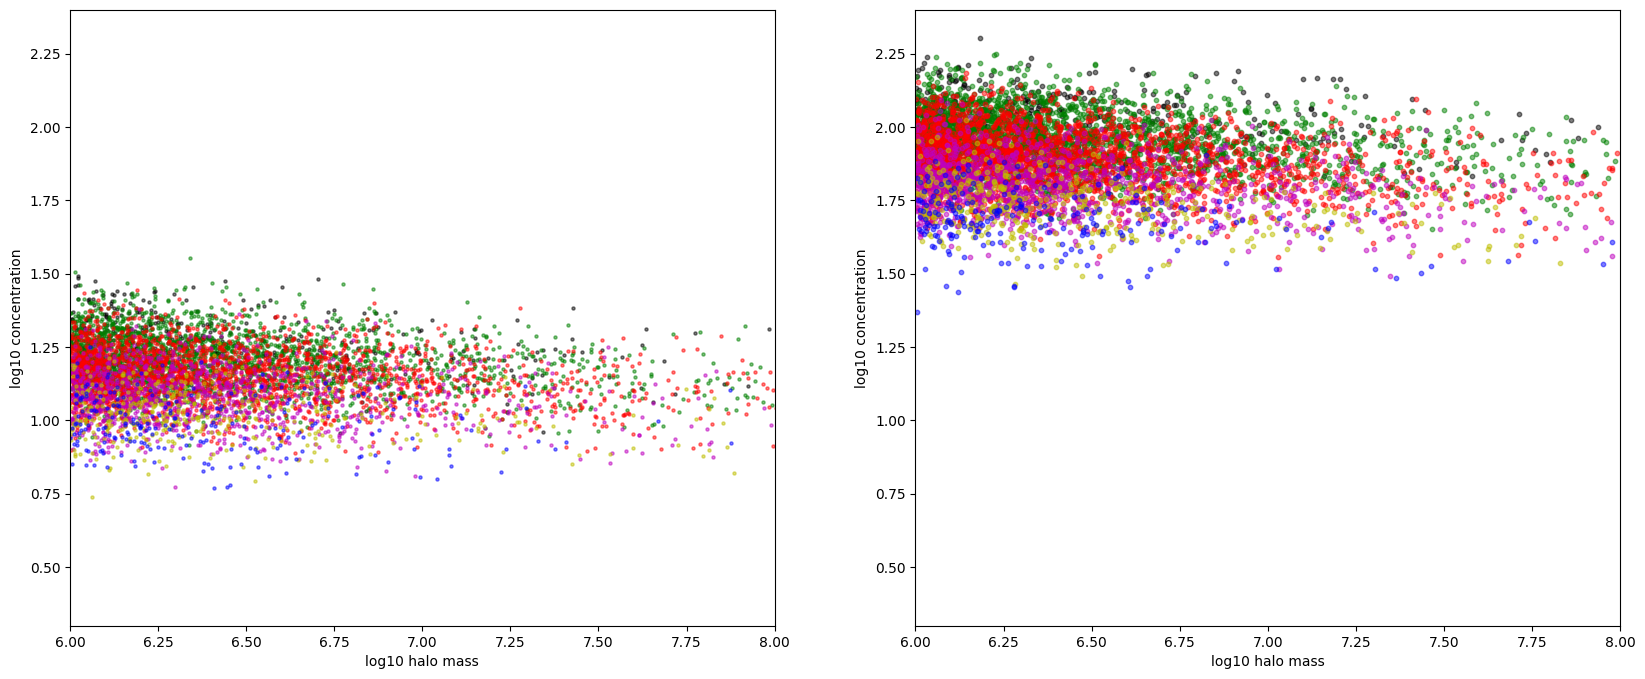

In [10]:
from pyHalo.Halos.concentration import ConcentrationDiemerJoyce

class ModifiedDiemerJoyce(object):
    # note that pyHalo expects the first argument to be an instance of astropy for all concentration-mass relation classes;
    # when using the CDM preset model, you also need to specify scatter_dex, even if you don't include scatter in the modified class,
    # because the CDM preset model assumes a default scatter of 0.2 dex
    
    def __init__(self, cosmo, rescaling_factor, scatter_dex):
        
        self._rescaling_factor = rescaling_factor
        self._model_diemer_joyce = ConcentrationDiemerJoyce(cosmo, scatter=True, scatter_dex=scatter_dex)

    def nfw_concentration(self, m, z):
        """
        The custom class should have the nfw_concentration method that takes as input halo mass (mass definition 200 w.r.t rho_crit) 
        and redshift
        """
        # we call the nfw_concentration method in the DiemerJoyce class
        c = self._model_diemer_joyce.nfw_concentration(m, z)
        # and return it multiplied by some factor
        return self._rescaling_factor * c

zlens, zsource = 0.5, 2.5
realizationCDM_diemerjoyce = CDM(zlens, zsource, cone_opening_angle_arcsec=9.0, sigma_sub=0.0)
kwargs_concentration_model = {'custom_class': ModifiedDiemerJoyce, 'rescaling_factor': 5.0}
realizationCDM_modified_diemerjoyce = CDM(zlens, zsource, cone_opening_angle_arcsec=9.0, sigma_sub=0.0, 
                                concentration_model_subhalos='CUSTOM', 
                                 kwargs_concentration_model_subhalos=kwargs_concentration_model,
                                concentration_model_fieldhalos='CUSTOM', 
                                 kwargs_concentration_model_fieldhalos=kwargs_concentration_model)

# NOTE: colors correspond to redshift in the following figures
fig = plt.figure(1)
fig.set_size_inches(20, 8)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 5}
plot_mc_relation(ax1, realizationCDM_diemerjoyce, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 10}
plot_mc_relation(ax2, realizationCDM_modified_diemerjoyce, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 10}
ax1.set_xlim(6., 8.)
ax1.set_ylim(0.3, 2.4)
ax2.set_xlim(6.,8.)
ax2.set_ylim(0.3, 2.4)
ax1.set_xlabel('log10 halo mass')
ax1.set_ylabel('log10 concentration')
ax2.set_xlabel('log10 halo mass')
ax2.set_ylabel('log10 concentration')



### Power law in peak height
You have the option of specifying a variety of mass-concentration relations, including customized ones.

The default setting is the model presenteed by Diemer and Joyce (2019) https://arxiv.org/pdf/1809.07326.pdf  

Alternatively, you can use a model that is a power law the peak height $\nu = \frac{\delta_c}{\sigma\left(M, z\right)}$, where $\sigma\left(M, z\right)$ is the mass variance of the matter power spectrum filtered on a scale $R \propto M^{\frac{1}{3}}$ (see https://arxiv.org/pdf/1909.02573.pdf for details). 

The form of this model is given by:
\begin{equation}
c\left(m,z\right) = c_0 \left(\frac{\nu\left(m,z\right)}{\nu\left(10^8 M_{\odot}, z\right)}\right)^{-\beta} \left(\frac{\nu\left(m, 0\right)}{\nu\left(m,z\right)}\right)^{\zeta}
\end{equation}

In [3]:
zlens, zsource = 0.6, 3.0
kwargs_concentration_model = {'scatter': False}
# the default model is that of Diemer and Joyce (2019)
realizationCDM_default = CDM(zlens, zsource, cone_opening_angle_arcsec=12.0, sigma_sub=0.0,
                            kwargs_concentration_model_subhalos=kwargs_concentration_model, 
                            kwargs_concentration_model_fieldhalos=kwargs_concentration_model)

kwargs_concentration_model = {'c0': 16.0, 'beta': 0.8, 'zeta': 1.0, 'scatter': False}
realizationCDM_peak_height_1 = CDM(zlens, zsource, cone_opening_angle_arcsec=12.0, sigma_sub=0.0, 
                                concentration_model_subhalos='PEAK_HEIGHT_POWERLAW', 
                                 kwargs_concentration_model_subhalos=kwargs_concentration_model,
                                concentration_model_fieldhalos='PEAK_HEIGHT_POWERLAW', 
                                 kwargs_concentration_model_fieldhalos=kwargs_concentration_model)

kwargs_concentration_model = {'c0': 16.0, 'beta': 3.8, 'zeta': 1.0, 'scatter': False}
realizationCDM_peak_height_2 = CDM(zlens, zsource, cone_opening_angle_arcsec=12.0, sigma_sub=0.0, 
                                concentration_model_subhalos='PEAK_HEIGHT_POWERLAW', 
                                 kwargs_concentration_model_subhalos=kwargs_concentration_model,
                                concentration_model_fieldhalos='PEAK_HEIGHT_POWERLAW', 
                                 kwargs_concentration_model_fieldhalos=kwargs_concentration_model)

(0.3, 2.0)

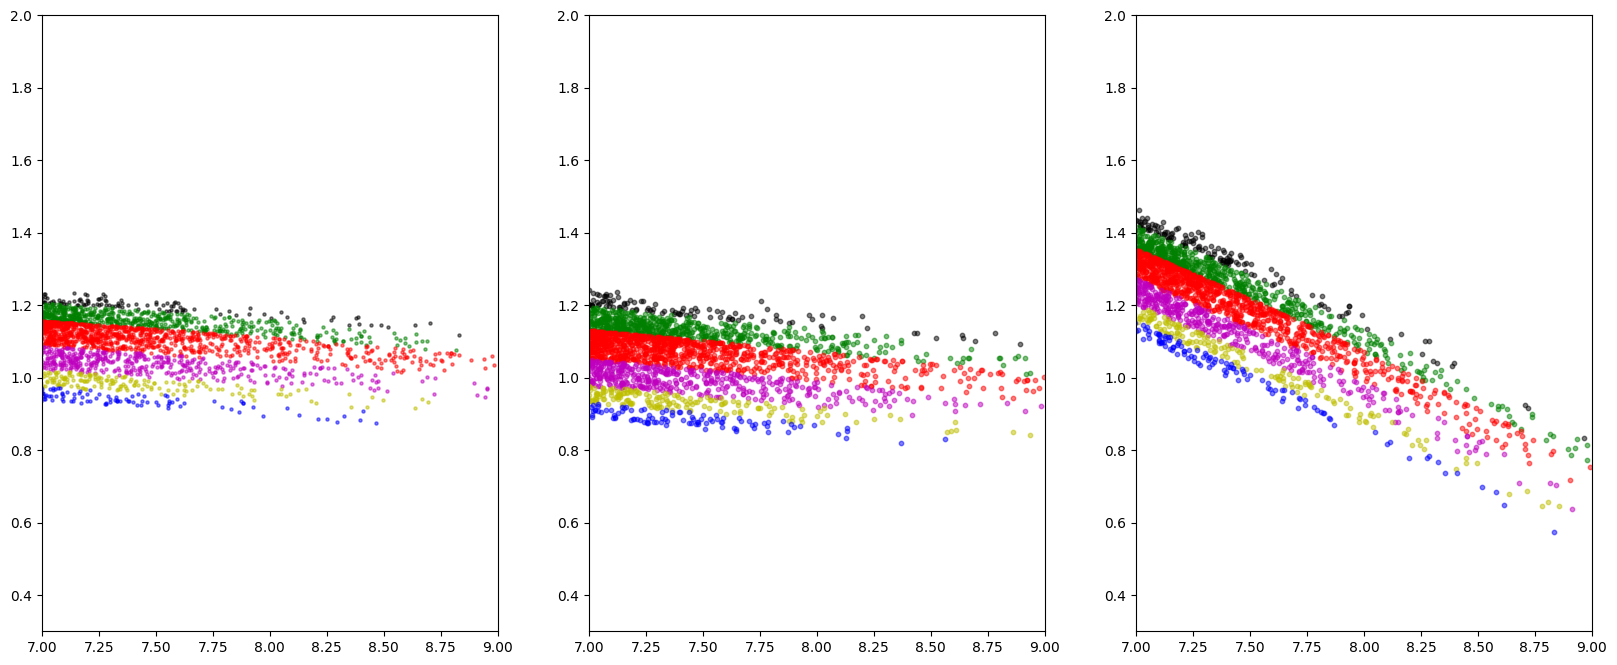

In [4]:
fig = plt.figure(1)
fig.set_size_inches(20, 8)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 5}
plot_mc_relation(ax1, realizationCDM_default, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 10}
plot_mc_relation(ax2, realizationCDM_peak_height_1, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 10}
plot_mc_relation(ax3, realizationCDM_peak_height_2, kwargs_plot)
ax1.set_xlim(7., 9.)
ax1.set_ylim(0.3, 2.0)
ax2.set_xlim(7.,9.)
ax2.set_ylim(0.3, 2.0)
ax3.set_xlim(7., 9.)
ax3.set_ylim(0.3, 2.0)

# HERE AGAIN COLORS CORRESPOND TO HALO REDSHIFTS, black is lowest redshift and blue is highest redshift

### An arbitrary MC relation 

You can specify an arbitrary MC relation by setting up a custom class

In [5]:
class PowerLawMassSinWave(object):
    # note that pyHalo expects the first argument to be an instance of astropy for all concentration-mass relation classes
    def __init__(self, cosmo, norm, log_slope, scatter_dex=None):
        self._norm = norm
        self._log_slope = log_slope
    def nfw_concentration(self, m, z):
        f = 1.0
        oscillations = np.sin( 2*np.pi * f * np.log10( m/10**8) )
        c = abs(self._norm * oscillations * (m/10**8) ** self._log_slope)
        # ignore scatter for now
        return abs(self._norm * oscillations * (m/10**8) ** self._log_slope)

zlens, zsource = 0.5, 2.5
kwargs_concentration_model = {'custom_class': PowerLawMassSinWave, 'norm': 16.0, 'log_slope': -0.25}
realizationCDM_peak_height_oscillations = CDM(zlens, zsource, cone_opening_angle_arcsec=9.0, sigma_sub=0.0, 
                                concentration_model_subhalos='CUSTOM', 
                                 kwargs_concentration_model_subhalos=kwargs_concentration_model,
                                concentration_model_fieldhalos='CUSTOM', 
                                 kwargs_concentration_model_fieldhalos=kwargs_concentration_model)
        

(0.3, 2.0)

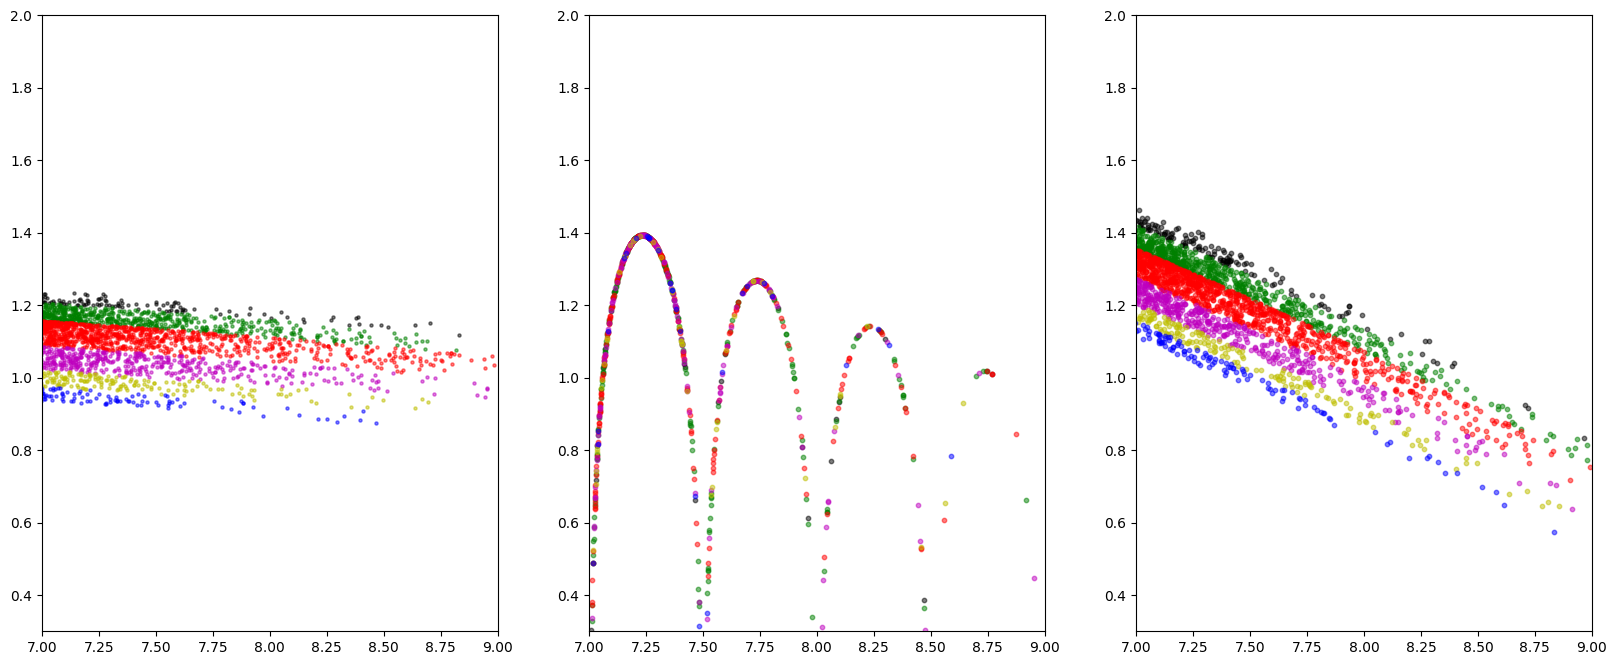

In [6]:
fig = plt.figure(1)
fig.set_size_inches(20, 8)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 5}
plot_mc_relation(ax1, realizationCDM_default, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 10}
plot_mc_relation(ax2, realizationCDM_peak_height_oscillations, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 10}
plot_mc_relation(ax3, realizationCDM_peak_height_2, kwargs_plot)
ax1.set_xlim(7., 9.)
ax1.set_ylim(0.3, 2.0)
ax2.set_xlim(7.,9.)
ax2.set_ylim(0.3, 2.0)
ax3.set_xlim(7., 9.)
ax3.set_ylim(0.3, 2.0)

In [7]:
# here we can try to match the prediction by Diemer and Joyce with a power law in peak height
kwargs_concentration_model = {'c0': 18, 'beta': 0.9, 'zeta': 1.1, 'scatter': False}
realization_peak_height_approx_diemer_joyce = CDM(zlens, zsource, cone_opening_angle_arcsec=12.0, sigma_sub=0.0, 
                                concentration_model_subhalos='PEAK_HEIGHT_POWERLAW', 
                                 kwargs_concentration_model_subhalos=kwargs_concentration_model,
                                concentration_model_fieldhalos='PEAK_HEIGHT_POWERLAW', 
                                 kwargs_concentration_model_fieldhalos=kwargs_concentration_model)

(0.9, 1.4)

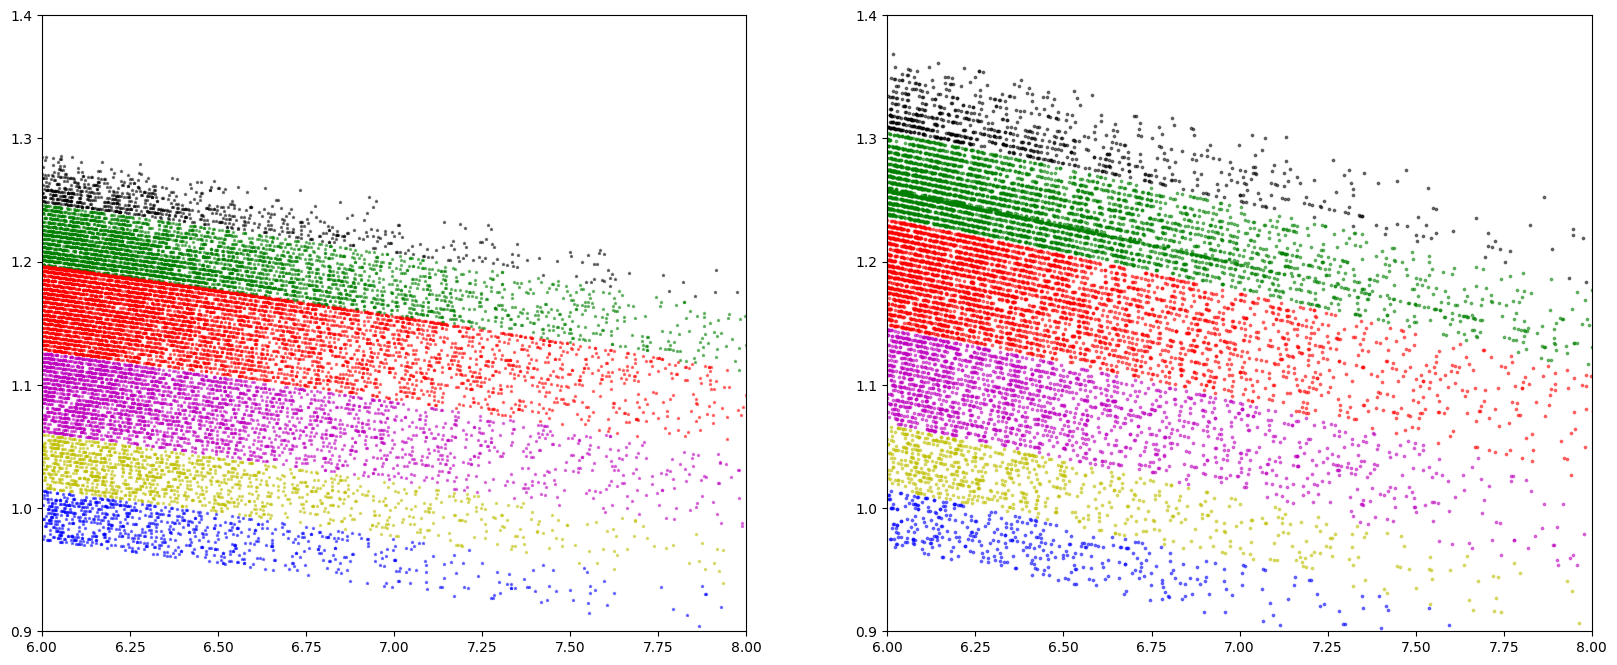

In [8]:
fig = plt.figure(1)
fig.set_size_inches(20, 8)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
kwargs_plot = {'marker': '*', 'alpha': 0.5, 's': 3}
plot_mc_relation(ax1, realizationCDM_default, kwargs_plot)
kwargs_plot = {'marker': 'o', 'alpha': 0.5, 's': 3}
plot_mc_relation(ax2, realization_peak_height_approx_diemer_joyce, kwargs_plot)
ax1.set_xlim(6., 8.)
ax1.set_ylim(0.9, 1.4)
ax2.set_xlim(6., 8.)
ax2.set_ylim(0.9, 1.4)
